In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

# Large Scale Text Classification for Sentiment Analysis

## Outline of the Session

- Limitations of the Vocabulary-Based Vectorizer
- The **Hashing Trick**
- **Online / Streaming** Text Feature Extraction and Classification
- **Parallel** Text Feature Extraction and Classification

## Scalability Issues

The `sklearn.feature_extraction.text.CountVectorizer` and `sklearn.feature_extraction.text.TfidfVectorizer` classes suffer from a number of scalability issues that all stem from the internal usage of the `vocabulary_` attribute (a Python dictionary) used to map the unicode string feature names to the integer feature indices.

The main scalability issues are:

- **Memory usage of the text vectorizer**: all the string representations of the features are loaded in memory
- **Parallelization problems for text feature extraction**: the `vocabulary_` would be a shared state: complex synchronization and overhead
- **Impossibility to do online or out-of-core / streaming learning**: the `vocabulary_` needs to be learned from the data: its size cannot be known before making one pass over the full dataset
    
    
To better understand the issue, let's have a look at how the `vocabulary_` attribute works. At `fit` time the tokens of the corpus are uniquely identified by a integer index and this mapping stored in the vocabulary:

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1)

vectorizer.fit([
    "The cat sat on the mat.",
])
vectorizer.vocabulary_

{u'cat': 0, u'mat': 1, u'on': 2, u'sat': 3, u'the': 4}

The vocabulary is used at `transform` time to build the occurence matrix:

In [14]:
X = vectorizer.transform([
    "The cat sat on the mat.",
    "This cat is a nice cat.",
]).toarray()

print(len(vectorizer.vocabulary_))
print(vectorizer.get_feature_names())
print(X)

5
[u'cat', u'mat', u'on', u'sat', u'the']
[[1 1 1 1 2]
 [2 0 0 0 0]]


Let's refit with a slightly larger corpus:

In [15]:
vectorizer = CountVectorizer(min_df=1)

vectorizer.fit([
    "The cat sat on the mat.",
    "The quick brown fox jumps over the lazy dog.",
])
vectorizer.vocabulary_

{u'brown': 0,
 u'cat': 1,
 u'dog': 2,
 u'fox': 3,
 u'jumps': 4,
 u'lazy': 5,
 u'mat': 6,
 u'on': 7,
 u'over': 8,
 u'quick': 9,
 u'sat': 10,
 u'the': 11}

The `vocabulary_` is (logarithmically) growing with the size of the training corpus. Note that we could not have built the vocabularies in parallel on the 2 text documents as they share some words, hence would require some kind of shared datastructure or synchronization barrier which is complicated to setup, especially if we want to distribute the processing on a cluster.

With this new vocabulary, the dimensionality of the output space is now larger:

In [16]:
X = vectorizer.transform([
    "The cat sat on the mat.",
    "This cat is a nice cat.",
]).toarray()

print(len(vectorizer.vocabulary_))
print(vectorizer.get_feature_names())
print(X)

12
[u'brown', u'cat', u'dog', u'fox', u'jumps', u'lazy', u'mat', u'on', u'over', u'quick', u'sat', u'the']
[[0 1 0 0 0 0 1 1 0 0 1 2]
 [0 2 0 0 0 0 0 0 0 0 0 0]]


## The Sentiment 140 Dataset

To illustrate the scalability issues of the vocabulary-based vectorizers, let's load a more realistic dataset for a classical text classification task: sentiment analysis on tweets. The goal is to tell apart negative from positive tweets on a variety of topics.

In [17]:
%run ../fetch_data.py sentiment140

Using existing dataset folder:/home/sbulut/Downloads/parallel_ml_tutorial/datasets
Checking availability of the sentiment 140 dataset
Found archive: /home/sbulut/Downloads/parallel_ml_tutorial/datasets/trainingandtestdata.zip
Checking that the sentiment 140 CSV files exist...
=> Success!


Assuming that the `../fetch_data.py` script was run successfully the following files should be available:

In [18]:
import os

sentiment140_folder = os.path.join('..', 'datasets', 'sentiment140')
training_csv_file = os.path.join(sentiment140_folder, 'training.1600000.processed.noemoticon.csv')
testing_csv_file = os.path.join(sentiment140_folder, 'testdata.manual.2009.06.14.csv')

Those files were downloaded from the research archive of the http://www.sentiment140.com/ project. The first file was gathered using the twitter streaming API by running stream queries for the positive ":)" and negative ":(" emoticons to collect tweets that are explicitly positive or negative. To make the classification problem non-trivial, the emoticons were stripped out of the text in the CSV files:

In [19]:
ls -lh ../datasets/sentiment140/training.1600000.processed.noemoticon.csv

-rw-r--r-- 1 sbulut sbulut 228M Nov 23 14:53 ../datasets/sentiment140/training.1600000.processed.noemoticon.csv


In [20]:
!head -3 ../datasets/sentiment140/training.1600000.processed.noemoticon.csv

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
"0","1467810917","Mon Apr 06 22:19:53 PDT 2009","NO_QUERY","mattycus","@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds"


Let's parse the CSV files and load everything in memory. As loading everything can take up to 2GB, let's limit the collection to 100K tweets of each (positive and negative) out of the total of 1.6M tweets.

In [21]:
%%time
names = ('polarity', 'id', 'date', 'query', 'author', 'text')
data_train = pd.read_csv(training_csv_file, encoding='latin1', names=names)

CPU times: user 5.79 s, sys: 464 ms, total: 6.26 s
Wall time: 6.73 s


In [22]:
data_train.head(5)

,polarity,id,date,query,author,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [23]:
text_train_all = data_train['text']
target_train_all = data_train['polarity'].values

In [24]:
len(text_train_all), len(target_train_all)

(1600000, 1600000)

Let's display the first samples:

In [25]:
for text in text_train_all[:3]:
    print(text + "\n")

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds



In [26]:
print(target_train_all[:3])

[0 0 0]


A polarity of "0" means negative while a polarity of "4" means positive. All the positive tweets are at the end of the file:

In [27]:
for text in text_train_all[-3:]:
    print(text + "\n")

Are you ready for your MoJo Makeover? Ask me for details 

Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur 

happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H 



In [28]:
print(target_train_all[-3:])

[4 4 4]


Let's split the training CSV file into a smaller training set and a validation set with 100k random tweets each:

In [29]:
from sklearn.cross_validation import train_test_split

text_train_small, text_validation, target_train_small, target_validation = train_test_split(
    text_train_all, target_train_all, test_size=.5, random_state=42)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's open the manually annotated tweet files. The evaluation set also has neutral tweets with a polarity of "2" which we ignore in this example. In real a real life setting, modelling a neutral class is extremely important. I could be done by collecting random additional data from twitter, rejecting tweets with strong polarity markers such as smiley for instance. We leave this discussion for future work.

We can build the final evaluation set with only the positive and negative tweets of the evaluation CSV file:

In [30]:
data_test = pd.read_csv(testing_csv_file, names=names)
data_test.head(5)

,polarity,id,date,query,author,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [31]:
non_neutral_data_test = data_test[data_test['polarity'] != 2]

text_test_all = non_neutral_data_test['text']
target_test_all = non_neutral_data_test['polarity']

In [32]:
len(text_test_all), len(target_test_all)

(359, 359)

## The Hashing Trick

To workaround the limitations of the vocabulary-based vectorizers, one can use the hashing trick. Instead of building and storing an explicit mapping from the feature names to the feature indices in a Python dict, we can just use a hash function and a modulus operation:

In [33]:
from sklearn.utils.murmurhash import murmurhash3_bytes_u32

for word in u"the cat sat on the mat".split():
    word_bytes = word.encode('utf-8')
    print(u"{0} => {1}".format(
        word, murmurhash3_bytes_u32(word_bytes, 0) % 2 ** 20))

the => 761698
cat => 300839
sat => 122804
on => 735689
the => 761698
mat => 122997


This mapping is completely stateless and the dimensionality of the output space is explicitly fixed in advance (here we use a modulo `2 ** 20` which means roughly 1M dimensions). This makes it possible to workaround the limitations of the vocabulary based vectorizer both for parallelizability and online / out-of-core learning.

The `HashingVectorizer` class is an alternative to the `TfidfVectorizer` class with `use_idf=False` that internally uses the murmurhash hash function:

In [34]:
from sklearn.feature_extraction.text import HashingVectorizer

h_vectorizer = HashingVectorizer(encoding='latin-1')
h_vectorizer

HashingVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.float64'>, encoding='latin-1',
         input=u'content', lowercase=True, n_features=1048576,
         ngram_range=(1, 1), non_negative=False, norm=u'l2',
         preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None)

It shares the same "preprocessor", "tokenizer" and "analyzer" infrastructure:

In [35]:
analyzer = h_vectorizer.build_analyzer()
analyzer('This is a test sentence.')

[u'this', u'is', u'test', u'sentence']

We can vectorize our datasets into a scipy sparse matrix exactly as we would have done with the `CountVectorizer` or `TfidfVectorizer`, except that we can directly call the `transform` method: there is no need to `fit` as `HashingVectorizer` is a stateless transformer:

In [36]:
%time X_train_small = h_vectorizer.transform(text_train_small)

CPU times: user 21.2 s, sys: 548 ms, total: 21.8 s
Wall time: 21.6 s


The dimension of the output is fixed ahead of time to `n_features=2 ** 20` by default (nearly 1M features) to minimize the rate of collision on most classification problem while having reasonably sized linear models (1M weights in the `coef_` attribute):

In [37]:
X_train_small

<800000x1048576 sparse matrix of type '<type 'numpy.float64'>'
	with 9489952 stored elements in Compressed Sparse Row format>

As only the non-zero elements are stored, `n_features` has little impact on the actual size of the data in memory. We can combine the hashing vectorizer with a Passive-Aggressive linear model in a pipeline:

In [38]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline

h_pipeline = Pipeline((
    ('vec', HashingVectorizer(encoding='latin-1')),
    ('clf', PassiveAggressiveClassifier(C=1, n_iter=1)),
))

%time h_pipeline.fit(text_train_small, target_train_small).score(text_validation, target_validation)

CPU times: user 43.5 s, sys: 1.02 s, total: 44.5 s
Wall time: 44.2 s


0.76068499999999994

Let's check that the score on the validation set is reasonably in line with the set of manually annotated tweets:

In [39]:
h_pipeline.score(text_test_all, target_test_all)

0.79944289693593318

As the `text_train_small` dataset is not that big, we can still use a vocabulary based vectorizer to check that the hashing collisions are not causing any significant performance drop on the validation set (**WARNING** this is twice as slow as the hashing vectorizer version, skip this cell if your computer is too slow):

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_vec = TfidfVectorizer(encoding='latin-1', use_idf=False)
vocabulary_pipeline = Pipeline((
    ('vec', vocabulary_vec),
    ('clf', PassiveAggressiveClassifier(C=1, n_iter=1)),
))

%time vocabulary_pipeline.fit(text_train_small, target_train_small).score(text_validation, target_validation)

CPU times: user 34.8 s, sys: 3.35 s, total: 38.1 s
Wall time: 37.8 s


0.76229749999999996

We get almost the same score but almost twice as slower with also a big, slow to (un)pickle datastructure in memory:

In [41]:
len(vocabulary_vec.vocabulary_)

427384

More info and reference for the original papers on the Hashing Trick in the answers to this http://metaoptimize.com/qa question: [What is the Hashing Trick?](http://metaoptimize.com/qa/questions/6943/what-is-the-hashing-trick).

## Out-of-Core learning

Out-of-Core learning is the task of training a machine learning model on a dataset that does not fit in the main memory. This requires the following conditions:
    
- a **feature extraction** layer with **fixed output dimensionality**
- knowing the list of all classes in advance (in this case we only have positive and negative tweets)
- a machine learning **algorithm that supports incremental learning** (the `partial_fit` method in scikit-learn).

Let us simulate an infinite tweeter stream that can generate batches of annotated tweet texts and their polarity. We can do this by recombining randomly pairs of positive or negative tweets from our fixed dataset:

In [42]:
target_train_small

array([0, 4, 4, ..., 0, 0, 0])

In [43]:
from random import Random


class InfiniteStreamGenerator(object):
    """Simulate random polarity queries on the twitter streaming API"""
    
    def __init__(self, texts, targets, seed=0, batchsize=100):
        self.texts_pos = [text for text, target in zip(texts, targets)
                               if target > 2]
        self.texts_neg = [text for text, target in zip(texts, targets)
                               if target <= 2]
        self.rng = Random(seed)
        self.batchsize = batchsize

    def next_batch(self, batchsize=None):
        batchsize = self.batchsize if batchsize is None else batchsize
        texts, targets = [], []
        for i in range(batchsize):
            # Select the polarity randomly
            target = self.rng.choice((0, 4))
            targets.append(target)
            
            # Combine 2 random texts of the right polarity
            pool = self.texts_pos if target > 2 else self.texts_neg
            text = self.rng.choice(pool) + " " + self.rng.choice(pool)
            texts.append(text)
        return texts, targets

infinite_stream = InfiniteStreamGenerator(text_train_all, target_train_all)

In [45]:
texts_in_batch, targets_in_batch = infinite_stream.next_batch(batchsize=3)

In [46]:
for t in texts_in_batch:
    print(t + "\n")

Hmmm, random thoughts in my head...  spooky...  @tylor47 ALLO , by the way, i love you and your ghetto guitar 

Every curl I ever had in my life....was blown away by this monsoon outside...  not looking forward to Jeremy leaving today 

@Courtney_SODMG South Africa.... thought i told u !!! lol it was coold!! ughh  Don't know what to do today 



In [47]:
targets_in_batch

[4, 0, 0]

We can now use our infinte tweet source to train an online machine learning algorithm using the hashing vectorizer. Note the use of the `partial_fit` method of the `PassiveAggressiveClassifier` instance in place of the traditional call to the `fit` method that needs access to the full training set.

From time to time, we evaluate the current predictive performance of the model on our validation set that is guaranteed to not overlap with the infinite training set source:

In [48]:
n_batches = 1000
validation_scores = []
training_set_size = []

# Build the vectorizer and the classifier
h_vectorizer = HashingVectorizer(encoding='latin-1')
clf = PassiveAggressiveClassifier(C=1)

# Extract the features for the validation once and for all
X_validation = h_vectorizer.transform(text_validation)
classes = np.array([0, 4])

n_samples = 0
for i in range(n_batches):
    
    texts_in_batch, targets_in_batch = infinite_stream.next_batch()    
    n_samples += len(texts_in_batch)

    # Vectorize the text documents in the batch
    X_batch = h_vectorizer.transform(texts_in_batch)
    
    # Incrementally train the model on the new batch
    clf.partial_fit(X_batch, targets_in_batch, classes=classes)
    
    if n_samples % 100 == 0:
        # Compute the validation score of the current state of the model
        score = clf.score(X_validation, target_validation)
        validation_scores.append(score)
        training_set_size.append(n_samples)

    if i % 100 == 0:
        print("n_samples: {0}, score: {1:.4f}".format(n_samples, score))

n_samples: 100, score: 0.6007
n_samples: 10100, score: 0.7173
n_samples: 20100, score: 0.7478
n_samples: 30100, score: 0.7275
n_samples: 40100, score: 0.7429
n_samples: 50100, score: 0.7558
n_samples: 60100, score: 0.7562
n_samples: 70100, score: 0.7501
n_samples: 80100, score: 0.7556
n_samples: 90100, score: 0.7537


We can now plot the collected validation score values, versus the number of samples generated by the infinite source and feed to the model:

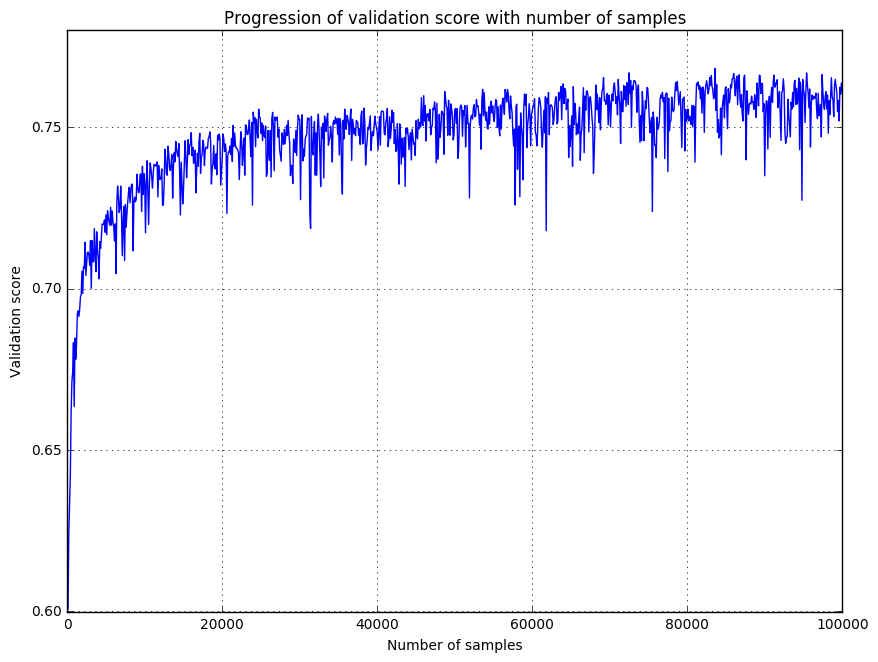

In [49]:
plt.plot(training_set_size, validation_scores)
plt.xlabel("Number of samples")
plt.ylabel("Validation score")
plt.title('Progression of validation score with number of samples');

## Parallelizing Text Classification

### Partitioning the Data and Training in Parallel

As the `HashingVectorizer` is stateless, one can use a separate instance (with the same parameters) in parallel or distributed processes to extract the features on independant partitions of a big text dataset. Each partition of extracted features can then be fed to independent instances of a linear classifier model on each computing node:

<img src="files/images/parallel_text_clf.png" style="width: 500px" />

### Final Linear Model Averaging

Once all the nodes are ready we can average the linear models:
    
<img src="files/images/parallel_text_clf_average.png" style="width: 500px" />

### Sample Implementation on the Tweet Data

Let's use IPython parallel to read partitions of the train CSV in different Python processes using the interactive IPython.parallel interface:

In [50]:
from ipyparallel import Client

client = Client()
len(client)

4

Let's tell each engine which partition of the data it will have to handle:

In [51]:
dv = client.direct_view()

In [52]:
dv.scatter('partition_ids', range(len(client)), block=True)

In [53]:
%px print(partition_ids)

[stdout:0] [0]
[stdout:1] [1]
[stdout:2] [2]
[stdout:3] [3]


In [54]:
%px partition_id = partition_ids[0]

In [55]:
%px print(partition_id)

[stdout:0] 0
[stdout:1] 1
[stdout:2] 2
[stdout:3] 3


Let's send all we need to the engines

In [56]:
from sklearn.feature_extraction.text import HashingVectorizer

h_vectorizer = HashingVectorizer(encoding='latin-1')
dv['h_vectorizer'] = h_vectorizer
dv['names'] = names
dv['training_csv_file'] = training_csv_file
dv['n_partitions'] = len(client)

In [57]:
%px print(training_csv_file)
%px print(n_partitions)

[stdout:0] ../datasets/sentiment140/training.1600000.processed.noemoticon.csv
[stdout:1] ../datasets/sentiment140/training.1600000.processed.noemoticon.csv
[stdout:2] ../datasets/sentiment140/training.1600000.processed.noemoticon.csv
[stdout:3] ../datasets/sentiment140/training.1600000.processed.noemoticon.csv
[stdout:0] 4
[stdout:1] 4
[stdout:2] 4
[stdout:3] 4


We are now ready to read the data partition from the CSV file, vectorize it, and train an indepenent model on each IPython.parallel engine:

In [60]:
%%px

import pandas as pd

max_count = 50000
print("Parsing %d items for partition %d..." % (max_count, partition_id))


data = pd.read_csv(training_csv_file, names=names, encoding='latin-1')
data = data[data['id'] % n_partitions == partition_id]

texts, targets = data['text'], data['polarity'].values

print("Shuffling the positive and negative examples...")

from sklearn.utils import shuffle
texts, targets = shuffle(texts, targets, random_state=1)

print("Vectorizing text data...")

vectors = h_vectorizer.transform(texts)

print("Fitting a linear model...")

from sklearn.linear_model import Perceptron
clf = Perceptron(n_iter=1).fit(vectors, targets)

print("Done!")

[stdout:0] 
Parsing 50000 items for partition 0...
Shuffling the positive and negative examples...
Vectorizing text data...
Fitting a linear model...
Done!
[stdout:1] 
Parsing 50000 items for partition 1...
Shuffling the positive and negative examples...
Vectorizing text data...
Fitting a linear model...
Done!
[stdout:2] 
Parsing 50000 items for partition 2...
Shuffling the positive and negative examples...
Vectorizing text data...
Fitting a linear model...
Done!
[stdout:3] 
Parsing 50000 items for partition 3...
Shuffling the positive and negative examples...
Vectorizing text data...
Fitting a linear model...
Done!


In [59]:
classifiers = dv.gather('clf', block=True)
classifiers

[Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
       n_iter=1, n_jobs=1, penalty=None, random_state=0, shuffle=True,
       verbose=0, warm_start=False),
 Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
       n_iter=1, n_jobs=1, penalty=None, random_state=0, shuffle=True,
       verbose=0, warm_start=False),
 Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
       n_iter=1, n_jobs=1, penalty=None, random_state=0, shuffle=True,
       verbose=0, warm_start=False),
 Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
       n_iter=1, n_jobs=1, penalty=None, random_state=0, shuffle=True,
       verbose=0, warm_start=False)]

We can now compute the average linear model:

In [ ]:
from copy import copy

def average_linear_model(models):
    """Compute a linear model that is the average of the others"""
    avg = copy(models[0])

    avg.coef_ = np.sum([m.coef_ for m in models], axis=0)
    avg.coef_ /= len(models)
    
    avg.intercept_ = np.sum([m.intercept_ for m in models], axis=0)
    avg.intercept_ /= len(models)

    return avg
    

clf = average_linear_model(classifiers)

Let's compare the score of the average model with the scores of the individual classifiers. The average models can have a better generalization than the individual models being averaged:

In [ ]:
clf.score(h_vectorizer.transform(text_test_all), target_test_all)

In [ ]:
for c in classifiers:
    print(c.score(h_vectorizer.transform(text_test_all), target_test_all))

Averaging linear models learned on different datasets that follow the same distribution is a form of Ensemble method. Other Ensemble methods include:
    
- Boosted models (see [Gradient Tree Boosting](http://scikit-learn.org/dev/modules/ensemble.html#gradient-tree-boosting) available in 0.13 and [AdaBoost](http://scikit-learn.org/dev/modules/ensemble.html#adaboost) in master),
- Bagging (Bootstrap Aggregating) as done in [Random Forests](http://scikit-learn.org/dev/modules/ensemble.html#random-forests). Decision Trees as the base model
- Other non-bootstrapped, randomized aggregate of Decision Trees such as [Extremely Randomized Trees](http://scikit-learn.org/dev/modules/ensemble.html#extremely-randomized-trees).
- Averaging the probabilistic estimate of a library of randomized and / or heterogeneous linear or non-linear models.
- Stacking, for instance: training a final Random Forest on the probabilistic class assignment output of a library of randomized and / or heterogeneous linear or non-linear models.

### Limitations of the Hashing Vectorizer

Using the Hashing Vectorizer makes it possible to implement streaming and parallel text classification but can also introduce some issues:
    
- The collisions can introduce too much noise in the data and degrade prediction quality,
- The `HashingVectorizer` does not provide "Inverse Document Frequency" reweighting (lack of a `use_idf=True` option).
- There is no easy way to inverse the mapping and find the feature names from the feature index.

The collision issues can be controlled by increasing the `n_features` parameters.

The IDF weighting might be reintroduced by appending a `TfidfTransformer` instance on the output of the vectorizer. However computing the `idf_` statistic used for the feature reweighting will require to do at least one additional pass over the training set before being able to start training the classifier: this breaks the online learning scheme.

The lack of inverse mapping (the `get_feature_names()` method of `TfidfVectorizer`) is even harder to workaround. That would require extending the `HashingVectorizer` class to add a "trace" mode to record the mapping of the most important features to provide statistical debugging information.

In the mean time to debug feature extraction issues, it is recommended to use `TfidfVectorizer(use_idf=False)` on a small-ish subset of the dataset to simulate a `HashingVectorizer()` instance that have the `get_feature_names()` method and no collision issues.